In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from dotenv import load_dotenv
from statsmodels.tsa.stattools import adfuller
from research.pipes.sql import SQLPipe
from research.utils import test_trading_liquidity

pd.options.display.float_format = '{:,.4f}'.format

load_dotenv()

USER = os.getenv('PSQL_USERNAME')
PASS = os.getenv('PSQL_PASSWORD')
DATABASE = 'crypto'
SCHEMA = 'hourly'
INTERVAL = '60T'

pipe = SQLPipe(SCHEMA, DATABASE, USER, PASS, INTERVAL)

In [2]:
# This will take a bit to run
vol = test_trading_liquidity(interval='1hour')
vol.to_csv('data/vol.csv')

In [3]:
data = pd.read_csv("data/18M30T.csv", index_col=0)

# vol = pd.read_csv('data/vol.csv', index_col=0)
low_vol = vol[vol < 25_000].index.to_list()
low_vol = [symbol.lower().replace("-","") for symbol in low_vol]

data = data[data["pvalue"] < 0.01]
data = data[data["hurst"] < 0.50]
data = data[~data['x'].isin(low_vol) & ~data['y'].isin(low_vol)]
excluded_values = []
data = data[~data['x'].isin(excluded_values) & ~data['y'].isin(excluded_values)]
data['compound_score'] = data['pvalue'] * data['hurst'] * data['halflife']

data = data.sort_values('compound_score').reset_index(drop=True)

data.head(25)

,x,y,tscore,pvalue,hurst,halflife,compound_score
0,dotusdt,vrausdt,-6.6723,0.0000,0.4188,180.8548,0.0000
1,jasmyusdt,lrcusdt,-6.6640,0.0000,0.4680,289.7851,0.0000
2,sunusdt,vetusdt,-6.4288,0.0000,0.3628,187.3646,0.0000
3,ckbusdt,stxusdt,-6.2646,0.0000,0.4337,221.3504,0.0000
4,imxusdt,jasmyusdt,-6.1534,0.0000,0.4346,144.7243,0.0000
5,xprusdt,arusdt,-6.1353,0.0000,0.4135,170.7869,0.0001
6,sunusdt,dashusdt,-6.1222,0.0000,0.4130,211.3069,0.0001
7,injusdt,pyrusdt,-5.9634,0.0000,0.4242,241.3183,0.0002
8,ckbusdt,ankrusdt,-5.9079,0.0000,0.3997,207.4956,0.0002
9,sunusdt,xlmusdt,-5.8519,0.0000,0.3860,224.2056,0.0003


In [4]:
i = 18
x = data.loc[i, "x"]
y = data.loc[i, "y"]
df = pipe.query_pairs_trading_backtest([x, y])
print(x,y)

linausdt ckbusdt


In [5]:
closes = np.log(df.xs(
    "close", level=1, axis=1
).rename(columns={0: x, 1: y}))

(12471,)


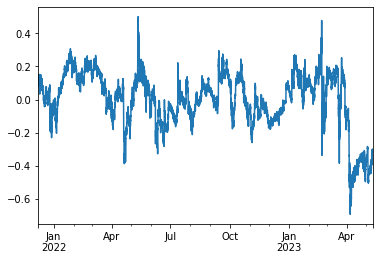

In [6]:
slicer = -13420

res = sm.OLS(
    endog=closes.iloc[slicer:, 1],
    exog=sm.add_constant(closes.iloc[slicer:, 0]),
).fit()

res.resid.plot()
print(res.resid.shape)

1.103761264814203 -0.9758101367731125


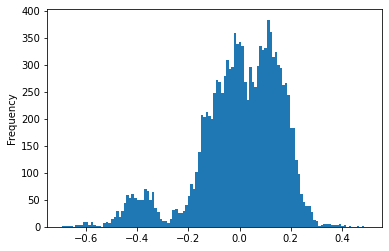

In [7]:
bins = np.arange(res.resid.min(), res.resid.max(), 0.01)
res.resid.plot(kind='hist', bins=bins)
print(kurtosis(res.resid), skew(res.resid))

In [8]:
def engle_granger(resids, level="1%", maxlag=1):
    test_results = adfuller(resids, maxlag=maxlag, regression="n")

    interpretation = test_results[0] < test_results[4][level]

    print("-------- Results ---------")
    print(f"Stationary at {level} confidence? {interpretation}")
    print(f"Critical value: {test_results[4][level]:.4f}")
    print(f"t-score for test: {test_results[0]:.4f}")
    print(f"p-score for test: {test_results[1]:.4f}")

engle_granger(res.resid)

-------- Results ---------
Stationary at 1% confidence? True
Critical value: -2.5659
t-score for test: -4.3474
p-score for test: 0.0000
